In [19]:
import numpy as np
import pandas as pd
from Evaluator import ModelEvaluator
import torch
import random
from matplotlib import pylab as plt
from IPython.display import clear_output
import copy

In [20]:
data=pd.read_csv("./datasets/Colcom2018CleanedScaled.csv",header=0,sep=';')
data=data[data.type=='malicious']
data.drop(columns=['type'] ,inplace=True)
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


In [21]:
data

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
4691,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.322222,-0.270588,-0.159145,-0.323559,-0.50
4692,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.322222,-0.270588,-0.159185,-0.323646,-0.50
4693,-0.174419,0.0,-0.333333,-0.229087,0.0,-0.200000,-0.164706,-0.092024,-0.235921,-0.25
4694,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.322222,-0.270588,-0.158578,-0.323299,-0.50
4695,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.322222,-0.211765,-0.138673,-0.323559,-0.50
...,...,...,...,...,...,...,...,...,...,...
7827,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.311111,-0.258824,-0.154290,-0.317647,-0.25
7828,-0.244186,4.0,-0.333333,-0.285957,0.0,-0.277778,-0.270588,-0.161208,-0.296868,-0.50
7829,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.311111,-0.258824,-0.154290,-0.317647,-0.25
7830,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.311111,-0.258824,-0.154290,-0.317647,-0.25


In [22]:
malData

array([[-0.29069767,  0.        , -0.66666667, ..., -0.1591447 ,
        -0.32355946, -0.5       ],
       [-0.29069767,  0.        , -0.66666667, ..., -0.15918516,
        -0.3236464 , -0.5       ],
       [-0.1744186 ,  0.        , -0.33333333, ..., -0.09202355,
        -0.23592062, -0.25      ],
       ...,
       [-0.29069767,  0.        , -0.66666667, ..., -0.15428964,
        -0.31764731, -0.25      ],
       [-0.29069767,  0.        , -0.66666667, ..., -0.15428964,
        -0.31764731, -0.25      ],
       [-0.29069767,  0.        , -0.66666667, ..., -0.15428964,
        -0.31764731, -0.25      ]])

## control

In [23]:
totalEpochs=1000
totalNumAdversarialData=500
saveValue=totalEpochs-totalNumAdversarialData
if saveValue<=0:
    saveValue=0
totalItemsConv=0

In [24]:
features=['A','B','C','D','F','G','H','I','j','k']
df=pd.DataFrame(columns=features)

In [25]:
class MalwareEnv():
    def __init__(self,totalEpochs):
        # Actions we can take, decrease, increse
        self.action_space = 20  
        # Set start 
        self.state = np.asarray(malData[random.randint(0,498),:])
        #model to evaluate the reward
        self.evaluator=ModelEvaluator()
        #units to move
        self.block=10
        #number of items saved
        self.savedItems=0
        #pointcritic
        self.pointCritic=totalEpochs-totalNumAdversarialData
        #loss
        self.hit=0
        
    def reset(self):
        self.state = np.asarray(malData[random.randint(0,498),:])
        
        
    def step(self, action):
        
        if(action<9):
            self.state[action]+=self.block
        elif(action>=9 and action<19):
            self.state[action-9]-=self.block
            
        
    def reward(self):
        reward=-1
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
            self.hit+=1
            reward=+10
            self.saveItem()
                 
        return reward    
    
    def saveItem(self):
        
        
        if self.hit>self.pointCritic:
            
            print("saveddddddddddddddddddddddddddddddddddd")
            
            formatier=self.state.reshape(1,-1)[0]
            df.loc[self.savedItems]=formatier
            self.savedItems+=1
            

    def render_np(self):
        return self.state
    

In [26]:


l1 = 10
l2 = 24
l3 = 72
l4 = 20
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [27]:
epochs = copy.copy(totalEpochs)
losses = [] 
env = MalwareEnv(totalEpochs)


for i in range(epochs): 
    env.reset()
    state_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0 
    state1 = torch.from_numpy(state_).float() 
    status = 1 
    while(status == 1): 
        qval = model(state1.cuda()) 
        qval_ = qval.data.cpu().numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,20)
        else:
            action_ = np.argmax(qval_)
        
        env.step(action_) 
        state2_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0
        state2 = torch.from_numpy(state2_).float() 
        reward = env.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,10).cuda())
        maxQ = torch.max(newQ) 
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        loss = loss_fn(X.cuda(), Y.cuda()) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: 
            status = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

saveddddddddddddddddddddddddddddddddddd
999 114.78498840332031


D:\programas\anaco\envs\latest tf 101021\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [28]:
losses
#clear_output(wait=True)

[0.22418445348739624,
 0.25812822580337524,
 0.5936785340309143,
 99.34392547607422,
 1.979130320250988e-05,
 104.08069610595703,
 0.06143058463931084,
 92.75202178955078,
 0.22508667409420013,
 0.003825434949249029,
 0.5396041870117188,
 2.2780354022979736,
 85.0141372680664,
 0.22560492157936096,
 93.310546875,
 0.195114403963089,
 1.9751157760620117,
 3.9005448343232274e-05,
 92.42762756347656,
 0.36729785799980164,
 0.09236621111631393,
 0.09974696487188339,
 94.6777572631836,
 0.2256452888250351,
 96.27339935302734,
 3.104600667953491,
 1.7347588539123535,
 308.7862548828125,
 503.08282470703125,
 10.601241111755371,
 137.03858947753906,
 193.7822723388672,
 0.2165212482213974,
 0.42870768904685974,
 98.57914733886719,
 0.47082072496414185,
 0.14163236320018768,
 0.22090280055999756,
 0.0004863099893555045,
 0.5031339526176453,
 2.5121681690216064,
 2.159000873565674,
 0.3745080232620239,
 78.3226089477539,
 0.009421068243682384,
 0.22172904014587402,
 96.13640594482422,
 0.176497

Text(0, 0.5, 'Loss')

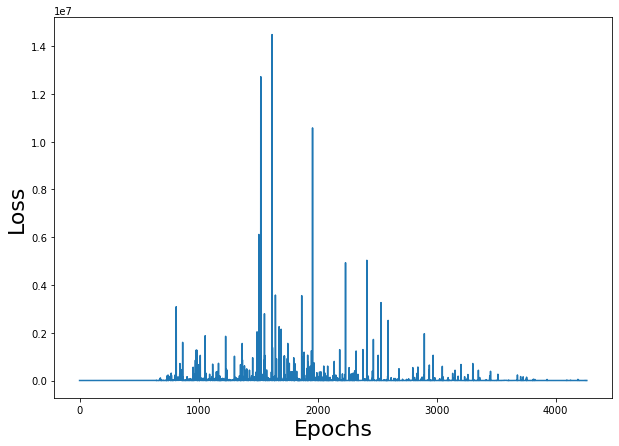

In [29]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [30]:
df

,A,B,C,D,F,G,H,I,j,k
0,-0.290698,10.0,-0.666667,-0.312383,10.0,-0.322222,-0.211765,-0.138673,9.676441,-20.50
1,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.300000,-0.247059,-10.146441,-0.310605,0.00
2,-0.290698,10.0,-0.666667,-0.312383,0.0,-0.311111,-0.258824,-0.142638,9.683396,-20.25
3,9.709302,10.0,-20.666667,-10.312383,0.0,9.700000,-10.152941,-10.099873,-30.310257,0.00
4,-10.290698,0.0,-0.666667,-0.312383,0.0,-0.300000,-0.247059,-10.146441,-0.310605,0.00
...,...,...,...,...,...,...,...,...,...,...
495,19.709302,10.0,19.333333,9.687617,0.0,219.700000,-0.247059,-0.127911,-0.310257,0.00
496,-0.093023,20.0,0.000000,29.853763,10.0,-0.111111,9.905882,-0.036069,-0.148195,0.00
497,-0.162791,0.0,-10.333333,9.767253,0.0,-10.200000,-10.152941,-0.114640,-0.245484,-0.50
498,9.709302,0.0,-0.666667,-0.312383,0.0,-0.311111,-0.258824,19.855582,-0.316604,-0.25


In [31]:
df.to_csv('datasets/Adversarial_data.csv' ,header=False,index=False)

In [32]:
torch.save(model.state_dict(), 'DRLMalwareModificator.sav')